<a href="https://colab.research.google.com/github/4lparslan/Image_Segmentation/blob/main/PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cyzlr9vx
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cyzlr9vx
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


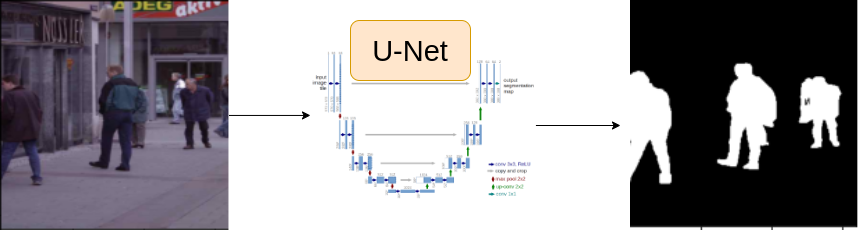

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25

# Learning Rate
LR = 0.003

IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
# dataframe
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[1]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

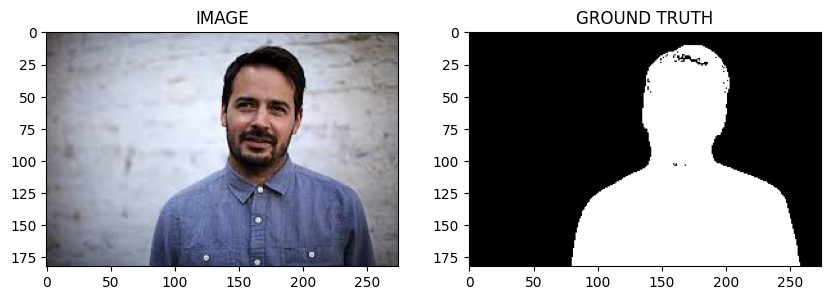

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE)
], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # np to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


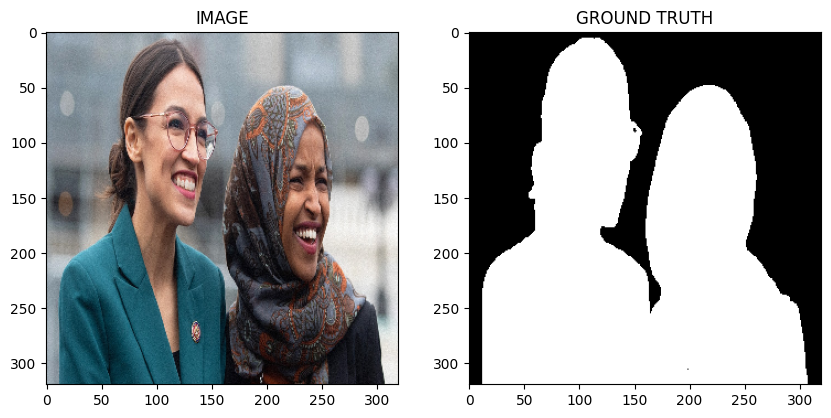

In [ ]:
idx = 200
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in train_loader: {len(train_loader)}")
print(f"Total number of batches in valid_loader: {len(valid_loader)}")

Total number of batches in train_loader: 15
Total number of batches in valid_loader: 4


In [ ]:
for image, mask in train_loader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

# batch_size, channel, height, width

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    #architecture
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits



In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 73.2MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # average loss
  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

  # average loss
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Saved Model
Epoch: 1 Train Loss: 0.3643696983655294 Valid Loss: 1.758186399936676


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Saved Model
Epoch: 2 Train Loss: 0.3356361150741577 Valid Loss: 0.32196948677301407


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Saved Model
Epoch: 3 Train Loss: 0.23184560437997181 Valid Loss: 0.2628193162381649


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Saved Model
Epoch: 4 Train Loss: 0.20411354502042134 Valid Loss: 0.25621507689356804


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Saved Model
Epoch: 5 Train Loss: 0.18436837792396546 Valid Loss: 0.22479645162820816


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Saved Model
Epoch: 6 Train Loss: 0.195016481479009 Valid Loss: 0.18682784587144852


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch: 7 Train Loss: 0.19243575483560563 Valid Loss: 0.20290029421448708


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 8 Train Loss: 0.1778876319527626 Valid Loss: 0.2249920889735222


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Saved Model
Epoch: 9 Train Loss: 0.1609192545215289 Valid Loss: 0.1787751242518425


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 10 Train Loss: 0.14939848482608795 Valid Loss: 0.27440448477864265


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


Epoch: 11 Train Loss: 0.1831815188129743 Valid Loss: 0.2386356070637703


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 12 Train Loss: 0.1740558500091235 Valid Loss: 0.25075291097164154


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


Epoch: 13 Train Loss: 0.19097298135360083 Valid Loss: 0.2324281595647335


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 14 Train Loss: 0.17061010897159576 Valid Loss: 0.25426601245999336


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 15 Train Loss: 0.13123816053072612 Valid Loss: 0.2484726645052433


100%|██████████| 4/4 [00:01<00:00,  3.67it/s]


Epoch: 16 Train Loss: 0.15840308219194413 Valid Loss: 0.20871776714920998


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch: 17 Train Loss: 0.1334966023763021 Valid Loss: 0.2163661140948534


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 18 Train Loss: 0.14678051620721816 Valid Loss: 0.2476901188492775


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 19 Train Loss: 0.1556287596623103 Valid Loss: 0.19757088273763657


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch: 20 Train Loss: 0.13256184657414755 Valid Loss: 0.19887625426054


100%|██████████| 4/4 [00:01<00:00,  3.84it/s]


Epoch: 21 Train Loss: 0.11054443071285884 Valid Loss: 0.22125281020998955


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Saved Model
Epoch: 22 Train Loss: 0.10504045163591703 Valid Loss: 0.17484698072075844


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch: 23 Train Loss: 0.08884650617837905 Valid Loss: 0.22627484425902367


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Epoch: 24 Train Loss: 0.1210324431459109 Valid Loss: 0.26838573068380356


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

Epoch: 25 Train Loss: 0.11392289598782858 Valid Loss: 0.22190508618950844


# Task 9 : Inference

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

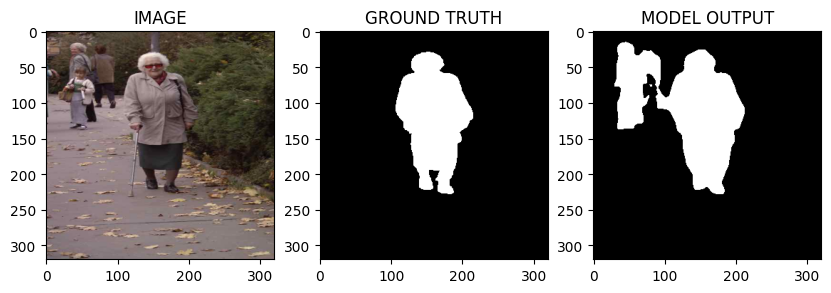

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya